##Import Modules

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical     #One-Hot Encoding

##Read Dataset and Normalization

In [4]:
#Read Dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#Normalization
X_train = X_train.astype("float32")/255.0        #shape = (60000, 28, 28)
X_test = X_test.astype("float32")/255.0          #shape = (10000, 28, 28)

#Batch size
X_train = np.expand_dims(X_train, axis = -1)    #shape = (60000, 28, 28, 1)
X_test = np.expand_dims(X_test, axis = -1)      #shape = (10000, 28, 28, 1)


#One-Hot Encoding

# Befor t0_categorical: y_train equals to [5 0 4 ..... 5 6 8]
#After to_categorical: y_train = [1 0 0 0 ... 0],.....

#convert class vectors to binary class matrices
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)


11493376/11490434 [==============================] - 0s 0us/step


##Main part of network - CNN

In [5]:
#Start defining the input tensor
#we define input_1 beacause keras ducument say:"When using Conv2D as the first layer in a model, provide the keyword argument input_shape". 
input_1 = layers.Input(shape=(28, 28, 1))

#Define layers

x = layers.Conv2D(32, (5, 5))(input_1)    #number of filter = 32 , dimension of filter = (5, 5)
x = layers.BatchNormalization()(x)
x = layers.PReLU()(x)

x = layers.Conv2D(32, (5, 5))(x)          #number of filter = 32 , dimension of filter = (5, 5)         
x = layers.BatchNormalization()(x)
x = layers.PReLU()(x)

x = layers.Conv2D(64, (5, 5))(x)          #number of filter = 64 , dimension of filter = (5, 5)
x = layers.BatchNormalization()(x)
x = layers.PReLU()(x)

x = layers.Conv2D(64, (5, 5))(x)          #number of filter = 64 , dimension of filter = (5, 5)
x = layers.BatchNormalization()(x)
x = layers.PReLU()(x)

x = layers.Conv2D(128, (5, 5))(x)         #number of filter = 128 , dimension of filter = (5, 5)
x = layers.BatchNormalization()(x)
x = layers.PReLU()(x)

x = layers.Conv2D(128, (5, 5))(x)        #number of filter = 128 , dimension of filter = (5, 5)
x = layers.BatchNormalization()(x)
x = layers.PReLU()(x)

#Make data to Flatten
x = layers.Flatten()(x)

#We choose 2 for visualizing in x-y (2D plane)
x = layers.Dense(2)(x)

out_1 = layers.PReLU(name= "out_1")(x)    #Output of 2 neurons we define 

out_2 = layers.Dense(10, activation= "softmax")(out_1)   #this is main output for mnist dataset and softmax

##Center Loss network

In [6]:
#Lambda_c is a constant for center loss function
lambda_c = 1                               
input_2 = layers.Input(shape=(1,))          # This is input number[0, 1, ....,9]                  

#Turns positive integers (indexes) into dense vectors of fixed size with Embedding

centers = layers.Embedding(10, 2)(input_2)    #Embeddding convert number to vector

# 10 is type of input for this layer[0, 1, 2, ... ,9] : input_dim
# 2 is the number of output for compare with 2 output in main network : output_dim

#Define center-loss function
def custom_layer(x):
  out_1 = x[0]
  centers = x[1]

  return tf.sqrt(tf.reduce_sum(tf.square(out_1 - centers[:, 0]), axis = 1, keepdims = True))
print(out_1.shape)
print(centers.shape)
print(centers[:,0])
intra_loss = layers.Lambda(custom_layer)([out_1, centers])

(None, 2)
(None, 1, 2)
KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")


##Complete Model and Compile

In [24]:
model_center_loss = Model([input_1, input_2], [out_2, intra_loss])

#Compile Model

#If the model has multiple outputs, you can use a different loss on each output by passing a dictionary or a list of losses.[custom_loss]
def custom_loss(y_true, y_pred):
  # y_pred equals to loss because we calculate loss in output of custom_layer
  return y_pred


model_center_loss.compile(optimizer= "sgd",
                          loss = ["categorical_crossentropy", custom_loss],  #An objective function is any callable with the signature loss = fn(y_true,y_pred)
                          loss_weights = [1, lambda_c/2],                    # scalar coefficients 
                          metrics=  ["accuracy"])


dummy_matrix1 = np.zeros((X_train.shape[0], 1))     #X_train.shape[0] = 60000
dummy_matrix2 = np.zeros((X_test.shape[0], 1))      #X_test.shape[0] = 10000

model_center_loss.fit(x = [X_train, y_train], y = [y_train_one_hot, dummy_matrix1],
                        batch_size = 32, epochs = 5, verbose = 1,
                        validation_data=([X_test, y_test], [y_test_one_hot, dummy_matrix2]))

#print(model_center_loss.summary())

Epoch 1/5
1875/1875 [==============================] - 18s 9ms/step - loss: 2.2415 - dense_7_loss: 2.1737 - lambda_3_loss: 0.1357 - dense_7_accuracy: 0.1889 - lambda_3_accuracy: 0.9259 - val_loss: 2.1526 - val_dense_7_loss: 2.0688 - val_lambda_3_loss: 0.1676 - val_dense_7_accuracy: 0.2124 - val_lambda_3_accuracy: 0.8959
Epoch 2/5
1875/1875 [==============================] - 16s 9ms/step - loss: 2.0800 - dense_7_loss: 2.0063 - lambda_3_loss: 0.1473 - dense_7_accuracy: 0.2357 - lambda_3_accuracy: 0.9031 - val_loss: 1.9597 - val_dense_7_loss: 1.8040 - val_lambda_3_loss: 0.3115 - val_dense_7_accuracy: 0.3044 - val_lambda_3_accuracy: 0.8003
Epoch 3/5
1875/1875 [==============================] - 16s 9ms/step - loss: 1.7647 - dense_7_loss: 1.6191 - lambda_3_loss: 0.2912 - dense_7_accuracy: 0.4391 - lambda_3_accuracy: 0.8130 - val_loss: 1.5882 - val_dense_7_loss: 1.4552 - val_lambda_3_loss: 0.2661 - val_dense_7_accuracy: 0.4986 - val_lambda_3_accuracy: 0.7731
Epoch 4/5
1875/1875 [=============

##Plot Model

(10000, 2)
(10, 2)


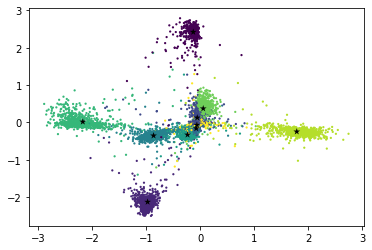

In [25]:
from keras import backend as K
model=Model(input_1,out_2)

func = K.function([model.input],[model.get_layer('out_1').output])
test_features= func([X_test])[0]
print(test_features.shape)

test_centers = np.dot(np.transpose(y_test_one_hot),test_features)
test_centers_count = np.sum(np.transpose(y_test_one_hot),axis=1,keepdims=True)
test_centers /= test_centers_count
print(test_centers.shape)

from matplotlib import pyplot as plt
%matplotlib inline
plt.scatter(test_features[:,0],test_features[:,1],c=y_test,edgecolor="none",s=5)
plt.scatter(test_centers[:,0],test_centers[:,1],c="black",marker="*",edgecolor="none",s=50)
plt.show()

